In [194]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/handson_jleague
!pip install -q japanize-matplotlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as RF
# データを表示する時に列を省略しないためのおまじない
pd.options.display.max_columns=None

from matplotlib import pyplot as plt
%matplotlib inline

# #日本語化matplotlibのインポート & 日本語のフォントを指定
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE

# データの読み込み
train = pd.read_csv("./data/train_all.csv")
test = pd.read_csv("./data/test_all.csv")
sample = pd.read_csv("./data/sample_submit.csv",header=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/handson_jleague'
/content/drive/MyDrive/handson_jleague


# 特徴量エンジニアリング

### 月、日、曜日変換

In [195]:
#月、日、曜日を取り出す
train['MONTH']=train['gameday'].apply(lambda x: int(x[0:2]))
train["MONTH"] = train["MONTH"].astype(int)
train['day']=train['gameday'].apply(lambda x: int(x[3:5]))
train["WEEK"] = train["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2])
#テストデータも同様に
test['MONTH']=test['gameday'].apply(lambda x: int(x[:2]))
test["MONTH"] = test["MONTH"].astype(int)
test['day']=test['gameday'].apply(lambda x: int(x[3:5]))
test["WEEK"] = test["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2])

# 第１節などのカラムから数字を取り出してmatch_numに入れる
train['match_num']=train['match'].apply(lambda x: int(x[x.find("第")+1: x.find("節")]))
test['match_num']=test['match'].apply(lambda x: int(x[x.find("第")+1: x.find("節")]))

# 祝日かどうかのフラグを作成
train['WE_hol'] = train['gameday'].apply(lambda x: 1 if '祝' in x else 0)
test['WE_hol'] = test['gameday'].apply(lambda x: 1 if '祝' in x else 0)

#不要カラムの削除
train=train.drop(columns=['gameday','match'])
test=test.drop(columns=['gameday','match'])

In [196]:
# WEEKデータの加工
train['WE_SAT'] = ((train['WEEK']== '土')).astype(int)
train['WE_SUN'] = ((train['WEEK']== "日")).astype(int)

test['WE_SAT'] = ((test['WEEK']== "土")).astype(int)
test['WE_SUN'] = ((test['WEEK']== "日")).astype(int)


# いらなそうなのでMONTH列削除
train = train.drop(columns='WEEK')
test = test.drop(columns='WEEK')

### チーム名変換

In [197]:
# ザスパ草津からザスパクサツ群馬に改名していたらしいので変更
train=train.replace('ザスパ草津','ザスパクサツ群馬')
test=test.replace('ザスパ草津','ザスパクサツ群馬')

### 天気表記の変更

In [198]:
# 天気の表記が細かすぎるものがあるので文字列を変更
def simple_weather(weather):
  if '雪' in weather:
    return '雨'
  elif '雨' in weather:
    return '雨'
  elif '曇' in weather:
    return '曇'
  elif '晴' in weather:
    return '晴'
  else:
    return weather

train['weather_simple']=train['weather'].apply(simple_weather)
test['weather_simple']=test['weather'].apply(simple_weather)

<ipython-input-199-4ea1abf4eaa2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weather_avg_attendance.index, y=weather_avg_attendance.values, palette="coolwarm")


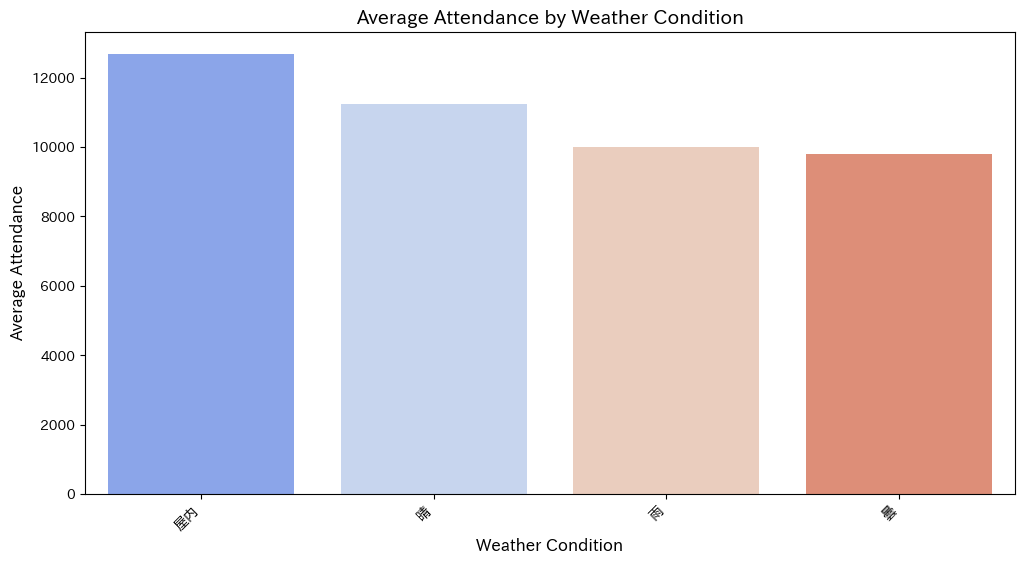

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

# 天気ごとの平均観客数を計算
weather_avg_attendance = train.groupby("weather_simple")["y"].mean().sort_values(ascending=False)

# 可視化
plt.figure(figsize=(12, 6))
sns.barplot(x=weather_avg_attendance.index, y=weather_avg_attendance.values, palette="coolwarm")

# ラベル設定
plt.xlabel("Weather Condition", fontsize=12)
plt.ylabel("Average Attendance", fontsize=12)
plt.title("Average Attendance by Weather Condition", fontsize=14)
plt.xticks(rotation=45, ha="right")

plt.show()


### テレビ局を番号化

In [200]:
train["tv_num"] = train["tv"].apply(lambda x : len(x.split("／")))
test["tv_num"] = test["tv"].apply(lambda x : len(x.split("／")))

## 会場ごとの前年度平均入場者数列の追加

In [201]:
average_stadium_values = {
    2012: {
        #2011年 J2チーム
        'コンサドーレ札幌': 10482,
        '水戸ホーリーホック': 3349,
        '栃木ＳＣ': 4939,
        'ザスパクサツ群馬': 3211,
        'ジェフユナイテッド千葉': 9680,
        'ＦＣ東京': 17562,
        '東京ヴェルディ': 5710,
        '横浜ＦＣ': 5770,
        '湘南ベルマーレ': 6943,
        'カターレ富山': 3275,
        'ＦＣ岐阜': 4120,
        '京都サンガF.C.': 6294,
        'ガイナーレ鳥取': 3692,
        'ファジアーノ岡山': 7258,
        '徳島ヴォルティス': 5207,
        '愛媛ＦＣ': 3475,
        'ギラヴァンツ北九州': 4051,
        'サガン鳥栖': 7731,
        'ロアッソ熊本': 6928,
        '大分トリニータ': 8779,
        # 2011年 J1チーム
        'ベガルタ仙台': 15656,
        'モンテディオ山形': 9325,
        '鹿島アントラーズ': 16156,
        '浦和レッズ': 33910,
        '大宮アルディージャ': 9099,
        '柏レイソル': 11917,
        '川崎フロンターレ': 17340,
        '横浜Ｆ・マリノス': 21038,
        'ヴァンフォーレ甲府': 12106,
        'アルビレックス新潟': 26049,
        '清水エスパルス': 15801,
        'ジュビロ磐田': 11796,
        '名古屋グランパス': 16741,
        'ガンバ大阪': 16411,
        'セレッソ大阪': 14145,
        'ヴィッセル神戸': 13233,
        'サンフレッチェ広島': 13203,
        'アビスパ福岡': 10415,
        # 2011年のデータがない、、、チートになっているかも、最悪NaNにする
        'ＦＣ町田ゼルビア': 3627,
        '松本山雅ＦＣ': 9531,
        'Ｖ・ファーレン長崎': 5503,
        'カマタマーレ讃岐': 3317
    }
}

# 年ごと＆チームごとに値を割り当て
for year, teams in average_stadium_values.items():
    for team, avg_value in teams.items():
        train.loc[(train['year'] == year) & (train['home'] == team), 'stadium_average_prev_year'] = avg_value

In [202]:
# 1. 各年の各チームの平均観客動員数を計算
average_attendance = train.groupby(['year', 'home_team'])['y'].mean().reset_index()
average_attendance.rename(columns={'y': 'stadium_average_prev_year'}, inplace=True)

# 小数点以下を切り捨て
average_attendance['stadium_average_prev_year'] = np.floor(average_attendance['stadium_average_prev_year'])

# 2. 前年度の平均を作成
average_attendance['year'] += 1  # 年を1年進めることで翌年のデータとして対応付け

# 3. データを結合し、既存の stadium_average_prev_year 列を補完
train = train.merge(average_attendance, on=['year', 'home_team'], how='left', suffixes=('', '_calculated'))

# 4. 既存列があれば補完、なければ新しい列を作成
if 'stadium_average_prev_year' in train.columns:
    # 既存列を補完
    train['stadium_average_prev_year'] = train['stadium_average_prev_year'].combine_first(train['stadium_average_prev_year_calculated'])
else:
    # 新しい列を作成
    train['stadium_average_prev_year'] = train['stadium_average_prev_year_calculated']

# 5. 不要な列を削除
train.drop(columns=['stadium_average_prev_year_calculated'], inplace=True)

# 小数点以下を切り捨て（必要に応じて再度適用）
train['stadium_average_prev_year'] = np.floor(train['stadium_average_prev_year'])


In [203]:
# 手入力の値を辞書で定義
manual_values = {
    'Ｖ・ファーレン長崎': 5503,
    'カマタマーレ讃岐': 3317
}

# 2013年のデータに対して、該当する home_team の stadium_average_prev_year を手入力の値で上書き
for team, value in manual_values.items():
    train.loc[(train['home_team'] == team) & (train['year'] == 2013), 'stadium_average_prev_year'] = value

In [204]:
# 手入力の値を辞書で定義
manual_values = {
    'カマタマーレ讃岐': 3317
}

# 2014年のデータに対して、該当する home_team の stadium_average_prev_year を手入力の値で上書き
for team, value in manual_values.items():
    train.loc[(train['home_team'] == team) & (train['year'] == 2014), 'stadium_average_prev_year'] = value

In [205]:
test['stadium_average_prev_year'] = np.nan

In [206]:
average_stadium_values = {
    2014: {'ベガルタ仙台': 14866.0, 'ヴァンフォーレ甲府': 12614.0, '名古屋グランパス': 16135.0, 'セレッソ大阪': 18819.0, 'サガン鳥栖': 12025.0, '柏レイソル': 12553.0, 'ガンバ大阪': 12285.0, '横浜Ｆ・マリノス': 27495.0, '川崎フロンターレ': 16644.0, 'サンフレッチェ広島': 16209.0, 'アルビレックス新潟': 26112.0, '徳島ヴォルティス': 4347.0, '大宮アルディージャ': 11137.0, 'ＦＣ東京': 25073.0, '清水エスパルス': 14136.0, 'ヴィッセル神戸': 11516.0, '浦和レッズ': 37100.0, '鹿島アントラーズ': 16418.0, '東京ヴェルディ': 6342.0, 'ＦＣ岐阜': 4525.0, 'ジュビロ磐田': 10894.0, '水戸ホーリーホック': 4630.0, '横浜ＦＣ': 6064.0, 'ファジアーノ岡山': 8574.0, 'ギラヴァンツ北九州': 3174.0, 'ロアッソ熊本': 6227.0, 'ジェフユナイテッド千葉': 10003.0, '湘南ベルマーレ': 9910.0, 'Ｖ・ファーレン長崎': 6167.0, 'コンサドーレ札幌': 10074.0, '栃木ＳＣ': 4921.0, 'ザスパクサツ群馬': 3570.0, 'カマタマーレ讃岐': 3317.0, '愛媛ＦＣ': 3950.0, 'アビスパ福岡': 5727.0, '大分トリニータ': 11915.0, 'モンテディオ山形': 7019.0, '松本山雅ＦＣ': 11041.0, 'カターレ富山': 4474.0, '京都サンガF.C.': 7891.0}

}
# average_stadium列を初期化
#train['stadium_average_prev_year'] = np.nan

# 年ごと＆チームごとに値を割り当て
for year, teams in average_stadium_values.items():
    for team, avg_value in teams.items():
        test.loc[(test['year'] == year) & (test['home'] == team), 'stadium_average_prev_year'] = avg_value


## 外れ値除去と正規化

In [207]:
#外れ値（観客数０）の除去
train=train[train['y']>0]

#log1p(numpyの関数)を適用、対数をとる
#train['y']=np.log1p(train["y"])

# 各会場のキャパについても正規化しておく（データのスケールを整える）
#train['capa']=np.log1p(train['capa'])
#test['capa']=np.log1p(test['capa'])

### 月を変換

In [208]:
# MONTHデータの加工
# J1の試合で11月の試合１２月の試合、J2の試合で11月の試合を判定するカラムの作成
train['J1_Nov'] = ((train['stage']== 'Ｊ１')&(train['MONTH']==11)).astype(int)
train['J1_Dec'] = ((train['stage']== 'Ｊ１')&(train['MONTH']==12)).astype(int)
train['J2_Nov'] = ((train['stage']== 'Ｊ２')&(train['MONTH']==11)).astype(int)
test['J1_Nov'] = ((test['stage']== 'Ｊ１')&(test['MONTH']==11)).astype(int)
test['J1_Dec'] = ((test['stage']== 'Ｊ１')&(test['MONTH']==12)).astype(int)
test['J2_Nov'] = ((test['stage']== 'Ｊ２')&(test['MONTH']==11)).astype(int)

# いらなそうなのでMONTH列削除
train = train.drop(columns='MONTH')
test = test.drop(columns='MONTH')

## チームランクの作成

In [209]:
train_rank = pd.read_csv("./data/train_all2.csv")
test_rank = pd.read_csv("./data/test_all2.csv")

In [210]:
train = pd.merge(train, train_rank[['id', 'home_rank', 'away_rank']], on='id', how='left')
test = pd.merge(test, test_rank[['id', 'home_rank', 'away_rank']], on='id', how='left')


各年の１試合目のデータの処理
前年度の順位で補完

In [211]:
prev_rank = {
    2011: {
        #2011年 J2チーム
        'コンサドーレ札幌': 3,
        '水戸ホーリーホック': 17,
        '栃木ＳＣ': 10,
        'ザスパクサツ群馬': 9,
        'ジェフユナイテッド千葉': 6,
        'ＦＣ東京': 1,
        '東京ヴェルディ': 5,
        '横浜ＦＣ': 18,
        '湘南ベルマーレ': 14,
        'カターレ富山': 16,
        'ＦＣ岐阜': 20,
        '京都サンガF.C.': 7,
        'ガイナーレ鳥取': 19,
        'ファジアーノ岡山': 13,
        '徳島ヴォルティス': 4,
        '愛媛ＦＣ': 15,
        'ギラヴァンツ北九州': 8,
        'サガン鳥栖': 2,
        'ロアッソ熊本': 11,
        '大分トリニータ': 12,
        # 2011年 J1チーム
        'ベガルタ仙台': 4,
        'モンテディオ山形': 18,
        '鹿島アントラーズ': 6,
        '浦和レッズ': 15,
        '大宮アルディージャ': 13,
        '柏レイソル': 1,
        '川崎フロンターレ': 11,
        '横浜Ｆ・マリノス': 5,
        'ヴァンフォーレ甲府': 16,
        'アルビレックス新潟': 14,
        '清水エスパルス': 10,
        'ジュビロ磐田': 8,
        '名古屋グランパス': 2,
        'ガンバ大阪': 3,
        'セレッソ大阪': 12,
        'ヴィッセル神戸': 9,
        'サンフレッチェ広島': 7,
        'アビスパ福岡': 17,
        # 2011年のデータがない
        'ＦＣ町田ゼルビア': -1,
        '松本山雅ＦＣ': -1,
        'Ｖ・ファーレン長崎': -1,
        'カマタマーレ讃岐': -1
    }
}

In [212]:
# trainを分割
train_2012 = train[train['year'] == 2012].copy()
train_2013 = train[train['year'] == 2013].copy()
train_2014 = train[train['year'] == 2014].copy()

In [213]:
train_2012.columns

Index(['id', 'y', 'year', 'stage', 'time', 'home', 'away', 'stadium', 'tv',
       'home_score', 'away_score', 'weather', 'temperature', 'humidity',
       'referee', 'home_team', 'home_01', 'home_02', 'home_03', 'home_04',
       'home_05', 'home_06', 'home_07', 'home_08', 'home_09', 'home_10',
       'home_11', 'away_team', 'away_01', 'away_02', 'away_03', 'away_04',
       'away_05', 'away_06', 'away_07', 'away_08', 'away_09', 'away_10',
       'away_11', 'address', 'capa', 'day', 'match_num', 'WE_hol', 'WE_SAT',
       'WE_SUN', 'weather_simple', 'tv_num', 'stadium_average_prev_year',
       'J1_Nov', 'J1_Dec', 'J2_Nov', 'home_rank', 'away_rank'],
      dtype='object')

In [214]:
def fill_rank_with_prev_rank(df, prev_rank):
    for index, row in df.iterrows():
        if pd.isna(row['home_rank']):
            prev_year = row['year'] - 1
            team = row['home']
            # prev_rank から前年順位を取得。見つからない場合は -1 などを返す
            df.loc[index, 'home_rank'] = prev_rank.get(prev_year, {}).get(team, -1)
        if pd.isna(row['away_rank']):
            prev_year = row['year'] - 1
            team = row['away']
            df.loc[index, 'away_rank'] = prev_rank.get(prev_year, {}).get(team, -1)

# 2012 年のデータに 2011 年の最終順位を適用
fill_rank_with_prev_rank(train_2012, prev_rank)

In [215]:
# 各ステージの最終節のデータを取得 (修正版)
def get_last_match_data(train_year, stage):
  """
  指定された年とステージの最終節データを取得する

  Args:
      train_year: 該当年(2012, 2013, 2014など)のデータフレーム
      stage: 'Ｊ１' or 'Ｊ２'

  Returns:
      最終節データを含むデータフレーム
  """
  train_year_stage = train_year[train_year['stage'] == stage]
  # 各年の最終節のmatch_numを取得する
  last_match_num = train_year_stage.groupby('year')['match_num'].max()
  # 最終節のデータを取得
  train_year_stage_last = train_year_stage[train_year_stage['match_num'].isin(last_match_num)]
  return train_year_stage_last

train_2012_j1_last = get_last_match_data(train_2012, 'Ｊ１')
train_2012_j2_last = get_last_match_data(train_2012, 'Ｊ２')

In [216]:
train_2012_j1_last.columns

Index(['id', 'y', 'year', 'stage', 'time', 'home', 'away', 'stadium', 'tv',
       'home_score', 'away_score', 'weather', 'temperature', 'humidity',
       'referee', 'home_team', 'home_01', 'home_02', 'home_03', 'home_04',
       'home_05', 'home_06', 'home_07', 'home_08', 'home_09', 'home_10',
       'home_11', 'away_team', 'away_01', 'away_02', 'away_03', 'away_04',
       'away_05', 'away_06', 'away_07', 'away_08', 'away_09', 'away_10',
       'away_11', 'address', 'capa', 'day', 'match_num', 'WE_hol', 'WE_SAT',
       'WE_SUN', 'weather_simple', 'tv_num', 'stadium_average_prev_year',
       'J1_Nov', 'J1_Dec', 'J2_Nov', 'home_rank', 'away_rank'],
      dtype='object')

In [217]:
def calculate_final_rank_per_stage(train_year_stage_last):
    final_rank = {}
    if train_year_stage_last.empty:
        return final_rank  # 空のデータフレームの場合は空の辞書を返す

    teams = set(train_year_stage_last['home'].unique()) | set(train_year_stage_last['away'].unique())
    for team in teams:
        try:
            home_rank = train_year_stage_last[train_year_stage_last['home'] == team]['home_rank'].iloc[0]
        except (IndexError, KeyError):
            home_rank = float('inf') # 存在しない場合は順位を無限大に設定
        try:
            away_rank = train_year_stage_last[train_year_stage_last['away'] == team]['away_rank'].iloc[0]
        except (IndexError, KeyError):
            away_rank = float('inf')

        # どちらを使うか(順位が低い方を採用)
        if home_rank < away_rank:
          final_rank[team] = home_rank
        elif home_rank == away_rank: # 順位が同じ場合(無限大含む)は-1などを設定
          final_rank[team] = -1
        else:
          final_rank[team] = away_rank

    return final_rank

In [218]:
# 各ステージの最終順位を計算 (修正後)
prev_rank[2012] = calculate_final_rank_per_stage(train_2012_j1_last)
prev_rank[2012].update(calculate_final_rank_per_stage(train_2012_j2_last))

In [219]:
# 2013 年のデータに 2012 年の最終順位を適用
fill_rank_with_prev_rank(train_2013, prev_rank)

# 2013 年の最終順位を計算
train_2013_j1_last = get_last_match_data(train_2013, 'Ｊ１')
train_2013_j2_last = get_last_match_data(train_2013, 'Ｊ２')

prev_rank[2013] = calculate_final_rank_per_stage(train_2013_j1_last)
prev_rank[2013].update(calculate_final_rank_per_stage(train_2013_j2_last))

# 2014 年のデータに 2013 年の最終順位を適用
fill_rank_with_prev_rank(train_2014, prev_rank)

# 2014 年の最終順位を計算 (※2014 年の最終順位は予測に使わないため、計算不要)
# train_2014_j1_last = get_last_match_data(train_2014, 'Ｊ１')
# train_2014_j2_last = get_last_match_data(train_2014, 'Ｊ２')

# prev_rank[2014] = calculate_final_rank_per_stage(train_2014_j1_last)
# prev_rank[2014].update(calculate_final_rank_per_stage(train_2014_j2_last))

In [220]:
# trainを結合して元の状態に戻す
train = pd.concat([train_2012, train_2013, train_2014])

### home,awayをくっつけて対戦カードのカラムにして列数削減

In [221]:
# train と test の両方を考慮してチーム名のリストを取得
all_teams = sorted(list(set(train['home'].unique()) | set(train['away'].unique()) | set(test['home'].unique()) | set(test['away'].unique())))

# train 用の処理
df_train = train.copy()
df_final_train = pd.DataFrame(0, index=df_train.index, columns=all_teams, dtype=int)

for index, row in df_train.iterrows():
    if row['home'] in all_teams and row['away'] in all_teams:
        df_final_train.loc[index, row['home']] = 1
        df_final_train.loc[index, row['away']] = 1

train_concat = pd.concat([train, df_final_train], axis=1)

# test 用の処理
df_test = test.copy()
df_final_test = pd.DataFrame(0, index=df_test.index, columns=all_teams, dtype=int)

for index, row in df_test.iterrows():
    if row['home'] in all_teams and row['away'] in all_teams:
        df_final_test.loc[index, row['home']] = 1
        df_final_test.loc[index, row['away']] = 1

test_concat = pd.concat([test, df_final_test], axis=1)

# 以降、train_concat, test_concat を使用して処理を進める

In [222]:
train_concat.columns

Index(['id', 'y', 'year', 'stage', 'time', 'home', 'away', 'stadium', 'tv',
       'home_score', 'away_score', 'weather', 'temperature', 'humidity',
       'referee', 'home_team', 'home_01', 'home_02', 'home_03', 'home_04',
       'home_05', 'home_06', 'home_07', 'home_08', 'home_09', 'home_10',
       'home_11', 'away_team', 'away_01', 'away_02', 'away_03', 'away_04',
       'away_05', 'away_06', 'away_07', 'away_08', 'away_09', 'away_10',
       'away_11', 'address', 'capa', 'day', 'match_num', 'WE_hol', 'WE_SAT',
       'WE_SUN', 'weather_simple', 'tv_num', 'stadium_average_prev_year',
       'J1_Nov', 'J1_Dec', 'J2_Nov', 'home_rank', 'away_rank', 'アビスパ福岡',
       'アルビレックス新潟', 'カターレ富山', 'カマタマーレ讃岐', 'ガイナーレ鳥取', 'ガンバ大阪', 'ギラヴァンツ北九州',
       'コンサドーレ札幌', 'サガン鳥栖', 'サンフレッチェ広島', 'ザスパクサツ群馬', 'ジェフユナイテッド千葉', 'ジュビロ磐田',
       'セレッソ大阪', 'ファジアーノ岡山', 'ベガルタ仙台', 'モンテディオ山形', 'ロアッソ熊本', 'ヴァンフォーレ甲府',
       'ヴィッセル神戸', '京都サンガF.C.', '名古屋グランパス', '大分トリニータ', '大宮アルディージャ', '川崎フロンターレ',
       '徳島ヴォルティス', '愛媛ＦＣ'

## ワンホットエンコーディング

In [223]:
# 制度に大きく影響のありそうなデータを選んで新しいデータフレームを作る
train_select=train_concat[['capa','WE_SAT',"WE_SUN", 'WE_hol','stage','J1_Nov','J1_Dec','J2_Nov','weather_simple','tv_num','y','match_num','stadium_average_prev_year', 'アビスパ福岡',
       'アルビレックス新潟', 'カターレ富山', 'カマタマーレ讃岐', 'ガイナーレ鳥取', 'ガンバ大阪', 'ギラヴァンツ北九州',
       'コンサドーレ札幌', 'サガン鳥栖', 'サンフレッチェ広島', 'ザスパクサツ群馬', 'ジェフユナイテッド千葉', 'ジュビロ磐田',
       'セレッソ大阪', 'ファジアーノ岡山', 'ベガルタ仙台', 'モンテディオ山形', 'ロアッソ熊本', 'ヴァンフォーレ甲府',
       'ヴィッセル神戸', '京都サンガF.C.', '名古屋グランパス', '大分トリニータ', '大宮アルディージャ', '川崎フロンターレ',
       '徳島ヴォルティス', '愛媛ＦＣ', '東京ヴェルディ', '松本山雅ＦＣ', '柏レイソル', '栃木ＳＣ', '横浜Ｆ・マリノス',
       '横浜ＦＣ', '水戸ホーリーホック', '浦和レッズ', '清水エスパルス', '湘南ベルマーレ', '鹿島アントラーズ', 'ＦＣ岐阜',
       'ＦＣ東京', 'ＦＣ町田ゼルビア', 'Ｖ・ファーレン長崎', 'home_rank', 'away_rank']]

test_select=test_concat[['capa','WE_SAT',"WE_SUN", 'WE_hol','stage','J1_Nov','J1_Dec','J2_Nov','weather_simple','tv_num','match_num','stadium_average_prev_year', 'アビスパ福岡',
       'アルビレックス新潟', 'カターレ富山', 'カマタマーレ讃岐', 'ガイナーレ鳥取', 'ガンバ大阪', 'ギラヴァンツ北九州',
       'コンサドーレ札幌', 'サガン鳥栖', 'サンフレッチェ広島', 'ザスパクサツ群馬', 'ジェフユナイテッド千葉', 'ジュビロ磐田',
       'セレッソ大阪', 'ファジアーノ岡山', 'ベガルタ仙台', 'モンテディオ山形', 'ロアッソ熊本', 'ヴァンフォーレ甲府',
       'ヴィッセル神戸', '京都サンガF.C.', '名古屋グランパス', '大分トリニータ', '大宮アルディージャ', '川崎フロンターレ',
       '徳島ヴォルティス', '愛媛ＦＣ', '東京ヴェルディ', '松本山雅ＦＣ', '柏レイソル', '栃木ＳＣ', '横浜Ｆ・マリノス',
       '横浜ＦＣ', '水戸ホーリーホック', '浦和レッズ', '清水エスパルス', '湘南ベルマーレ', '鹿島アントラーズ', 'ＦＣ岐阜',
       'ＦＣ東京', 'ＦＣ町田ゼルビア', 'Ｖ・ファーレン長崎', 'home_rank', 'away_rank']]

In [224]:
#一時的にデータを結合
# 結合前にtrainというフラグを作り、trainデータは1、testデータは0とする
train_select["train"]=1
test_select["train"]=0

# 結合
full_df = pd.concat([train_select, test_select],sort=False)

# ダミー変数化（ワンホットエンコーディング）
full_df = pd.get_dummies(full_df)

# trainフラグが1のものをtrain_selectとする。
train_select = full_df[full_df["train"]==1]
# trainフラグを削除
train_select = train_select.drop(columns="train")

# trainフラグが0のものをtest_selectとする。その後、trainフラグを削除
test_select = full_df[full_df["train"]==0]
test_select = test_select.drop(columns="train")

<ipython-input-224-20f7e769686b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_select["train"]=1
<ipython-input-224-20f7e769686b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_select["train"]=0


# データ書き出し

## 実行するな！！文字表記統一

In [ ]:
# 列名の変換例
train_select = train_select.rename(columns={
    'stage_Ｊ１': 'stage_J1',
    'stage_Ｊ２': 'stage_J2',
    'home_アビスパ福岡': 'home_abispa',
    'home_アルビレックス新潟': 'home_arubi',
    'home_カターレ富山': 'home_katale_toyama',
    'home_カマタマーレ讃岐': 'home_kamatamare_sanuki',
    'home_ガイナーレ鳥取': 'home_gainare_tottori',
    'home_ガンバ大阪': 'home_gamba_osaka',
    'home_ギラヴァンツ北九州': 'home_giravants_kitakyushu',
    'home_コンサドーレ札幌': 'home_consadole_sapporo',
    'home_サガン鳥栖': 'home_sagan_tosu',
    'home_サンフレッチェ広島': 'home_sanfrecce_hiroshima',
    'home_ザスパクサツ群馬': 'home_zaspakusatsu_gunma',
    'home_ジェフユナイテッド千葉': 'home_jeff_united_chiba',
    'home_ジュビロ磐田': 'home_jubilo_iwata',
    'home_セレッソ大阪': 'home_cerezo_osaka',
    'home_ファジアーノ岡山': 'home_fagiano_okayama',
    'home_ベガルタ仙台': 'home_vegalta_sendai',
    'home_モンテディオ山形': 'home_montedio_yamagata',
    'home_ロアッソ熊本': 'home_roasso_kumamoto',
    'home_ヴァンフォーレ甲府': 'home_vanfore_kofu',
    'home_ヴィッセル神戸': 'home_vissel_kobe',
    'home_京都サンガF.C.': 'home_kyoto_sanga_fc',
    'home_名古屋グランパス': 'home_nagoya_grampus',
    'home_大分トリニータ': 'home_oita_trinita',
    'home_大宮アルディージャ': 'home_omiya_ardija',
    'home_川崎フロンターレ': 'home_kawasaki_frontale',
    'home_徳島ヴォルティス': 'home_tokushima_vortis',
    'home_愛媛ＦＣ': 'home_ehime_fc',
    'home_東京ヴェルディ': 'home_tokyo_verdy',
    'home_松本山雅ＦＣ': 'home_matsumoto_yamaga_fc',
    'home_柏レイソル': 'home_kashiwa_reysol',
    'home_栃木ＳＣ': 'home_tochigi_sc',
    'home_横浜Ｆ・マリノス': 'home_yokohama_f_marinus',
    'home_横浜ＦＣ': 'home_yokohama_fc',
    'home_水戸ホーリーホック': 'home_mito_holyhock',
    'home_浦和レッズ': 'home_urawa_reds',
    'home_清水エスパルス': 'home_shimizu_spulse',
    'home_湘南ベルマーレ': 'home_shonan_bellmare',
    'home_鹿島アントラーズ': 'home_kashima_antlers',
    'home_ＦＣ岐阜': 'home_fc_gifu',
    'home_ＦＣ東京': 'home_fc_tokyo',
    'home_ＦＣ町田ゼルビア': 'home_fc_machida_zelvia',
    'home_Ｖ・ファーレン長崎': 'home_v_faren_nagasaki',
    # 以下同様に続けて、必要な分だけ追加していきます...
})

In [ ]:
train_select = train_select.rename(columns={
    'away_アビスパ福岡': 'away_abispa',
    'away_アルビレックス新潟': 'away_arubi',
    'away_カターレ富山': 'away_katale_toyama',
    'away_カマタマーレ讃岐': 'away_kamatamare_sanuki',
    'away_ガイナーレ鳥取': 'away_gainare_tottori',
    'away_ガンバ大阪': 'away_gamba_osaka',
    'away_ギラヴァンツ北九州': 'away_giravants_kitakyushu',
    'away_コンサドーレ札幌': 'away_consadole_sapporo',
    'away_サガン鳥栖': 'away_sagan_tosu',
    'away_サンフレッチェ広島': 'away_sanfrecce_hiroshima',
    'away_ザスパクサツ群馬': 'away_zaspakusatsu_gunma',
    'away_ジェフユナイテッド千葉': 'away_jeff_united_chiba',
    'away_ジュビロ磐田': 'away_jubilo_iwata',
    'away_セレッソ大阪': 'away_cerezo_osaka',
    'away_ファジアーノ岡山': 'away_fagiano_okayama',
    'away_ベガルタ仙台': 'away_vegalta_sendai',
    'away_モンテディオ山形': 'away_montedio_yamagata',
    'away_ロアッソ熊本': 'away_roasso_kumamoto',
    'away_ヴァンフォーレ甲府': 'away_v_faren_kofu',
    'away_ヴィッセル神戸': 'away_vissel_kobe',
    'away_京都サンガF.C.': 'away_kyoto_sanga_fc',
    'away_名古屋グランパス': 'away_nagoya_grampus',
    'away_大分トリニータ': 'away_oita_trinita',
    'away_大宮アルディージャ': 'away_omiya_ardija',
    'away_川崎フロンターレ': 'away_kawasaki_frontale',
    'away_徳島ヴォルティス': 'away_tokushima_vortis',
    'away_愛媛ＦＣ': 'away_ehime_fc',
    'away_東京ヴェルディ': 'away_tokyo_verdy',
    'away_松本山雅ＦＣ': 'away_matsumoto_yamaga_fc',
    'away_柏レイソル': 'away_kashiwa_reysol',
    'away_栃木ＳＣ': 'away_tochigi_sc',
    'away_横浜Ｆ・マリノス': 'away_yokohama_f_marinus',
    'away_横浜ＦＣ': 'away_yokohama_fc',
    'away_水戸ホーリーホック': 'away_mito_holyhock',
    'away_浦和レッズ': 'away_urawa_reds',
    'away_清水エスパルス': 'away_shimizu_spulse',
    'away_湘南ベルマーレ': 'away_shonan_bellmare',
    'away_鹿島アントラーズ': 'away_kashima_antlers',
    'away_ＦＣ岐阜': 'away_fc_gifu',
    'away_ＦＣ東京': 'away_fc_tokyo',
    'away_ＦＣ町田ゼルビア': 'away_fc_machida_zelvia',
    'away_Ｖ・ファーレン長崎': 'away_v_faren_nagasaki',
    'weather_simple_屋内': 'weather_simple_indoor',
    'weather_simple_晴': 'weather_simple_clear',
    'weather_simple_曇': 'weather_simple_cloudy',
    'weather_simple_雨': 'weather_simple_rainy',
    'J1_Nov': 'J1_November',
    'J1_Dec': 'J1_December',
    'J2_Nov': 'J2_November',
    'home_rank': 'home_rank',
    'away_rank': 'away_rank'
})

# 変換後の列名を表示
print(train_select.columns)


Index(['id', 'y', 'year', 'stage', 'time', 'home', 'away', 'stadium', 'tv',
       'home_score', 'away_score', 'weather', 'temperature', 'humidity',
       'referee', 'home_team', 'home_01', 'home_02', 'home_03', 'home_04',
       'home_05', 'home_06', 'home_07', 'home_08', 'home_09', 'home_10',
       'home_11', 'away_team', 'away_01', 'away_02', 'away_03', 'away_04',
       'away_05', 'away_06', 'away_07', 'away_08', 'away_09', 'away_10',
       'away_11', 'address', 'capa', 'day', 'match_num', 'holiday_flag',
       'WE_SAT', 'WE_SUN', 'weather_simple', 'tv_num',
       'stadium_average_prev_year', 'J1_Nov', 'J1_Dec', 'J2_Nov', 'home_rank',
       'away_rank'],
      dtype='object')


In [ ]:
# 列名の変換例
test_select = test_select.rename(columns={
    'stage_Ｊ１': 'stage_J1',
    'stage_Ｊ２': 'stage_J2',
    'home_アビスパ福岡': 'home_abispa',
    'home_アルビレックス新潟': 'home_arubi',
    'home_カターレ富山': 'home_katale_toyama',
    'home_カマタマーレ讃岐': 'home_kamatamare_sanuki',
    'home_ガイナーレ鳥取': 'home_gainare_tottori',
    'home_ガンバ大阪': 'home_gamba_osaka',
    'home_ギラヴァンツ北九州': 'home_giravants_kitakyushu',
    'home_コンサドーレ札幌': 'home_consadole_sapporo',
    'home_サガン鳥栖': 'home_sagan_tosu',
    'home_サンフレッチェ広島': 'home_sanfrecce_hiroshima',
    'home_ザスパクサツ群馬': 'home_zaspakusatsu_gunma',
    'home_ジェフユナイテッド千葉': 'home_jeff_united_chiba',
    'home_ジュビロ磐田': 'home_jubilo_iwata',
    'home_セレッソ大阪': 'home_cerezo_osaka',
    'home_ファジアーノ岡山': 'home_fagiano_okayama',
    'home_ベガルタ仙台': 'home_vegalta_sendai',
    'home_モンテディオ山形': 'home_montedio_yamagata',
    'home_ロアッソ熊本': 'home_roasso_kumamoto',
    'home_ヴァンフォーレ甲府': 'home_vanfore_kofu',
    'home_ヴィッセル神戸': 'home_vissel_kobe',
    'home_京都サンガF.C.': 'home_kyoto_sanga_fc',
    'home_名古屋グランパス': 'home_nagoya_grampus',
    'home_大分トリニータ': 'home_oita_trinita',
    'home_大宮アルディージャ': 'home_omiya_ardija',
    'home_川崎フロンターレ': 'home_kawasaki_frontale',
    'home_徳島ヴォルティス': 'home_tokushima_vortis',
    'home_愛媛ＦＣ': 'home_ehime_fc',
    'home_東京ヴェルディ': 'home_tokyo_verdy',
    'home_松本山雅ＦＣ': 'home_matsumoto_yamaga_fc',
    'home_柏レイソル': 'home_kashiwa_reysol',
    'home_栃木ＳＣ': 'home_tochigi_sc',
    'home_横浜Ｆ・マリノス': 'home_yokohama_f_marinus',
    'home_横浜ＦＣ': 'home_yokohama_fc',
    'home_水戸ホーリーホック': 'home_mito_holyhock',
    'home_浦和レッズ': 'home_urawa_reds',
    'home_清水エスパルス': 'home_shimizu_spulse',
    'home_湘南ベルマーレ': 'home_shonan_bellmare',
    'home_鹿島アントラーズ': 'home_kashima_antlers',
    'home_ＦＣ岐阜': 'home_fc_gifu',
    'home_ＦＣ東京': 'home_fc_tokyo',
    'home_ＦＣ町田ゼルビア': 'home_fc_machida_zelvia',
    'home_Ｖ・ファーレン長崎': 'home_v_faren_nagasaki',
    # 以下同様に続けて、必要な分だけ追加していきます...
})

In [ ]:
test_select = test_select.rename(columns={
    'away_アビスパ福岡': 'away_abispa',
    'away_アルビレックス新潟': 'away_arubi',
    'away_カターレ富山': 'away_katale_toyama',
    'away_カマタマーレ讃岐': 'away_kamatamare_sanuki',
    'away_ガイナーレ鳥取': 'away_gainare_tottori',
    'away_ガンバ大阪': 'away_gamba_osaka',
    'away_ギラヴァンツ北九州': 'away_giravants_kitakyushu',
    'away_コンサドーレ札幌': 'away_consadole_sapporo',
    'away_サガン鳥栖': 'away_sagan_tosu',
    'away_サンフレッチェ広島': 'away_sanfrecce_hiroshima',
    'away_ザスパクサツ群馬': 'away_zaspakusatsu_gunma',
    'away_ジェフユナイテッド千葉': 'away_jeff_united_chiba',
    'away_ジュビロ磐田': 'away_jubilo_iwata',
    'away_セレッソ大阪': 'away_cerezo_osaka',
    'away_ファジアーノ岡山': 'away_fagiano_okayama',
    'away_ベガルタ仙台': 'away_vegalta_sendai',
    'away_モンテディオ山形': 'away_montedio_yamagata',
    'away_ロアッソ熊本': 'away_roasso_kumamoto',
    'away_ヴァンフォーレ甲府': 'away_v_faren_kofu',
    'away_ヴィッセル神戸': 'away_vissel_kobe',
    'away_京都サンガF.C.': 'away_kyoto_sanga_fc',
    'away_名古屋グランパス': 'away_nagoya_grampus',
    'away_大分トリニータ': 'away_oita_trinita',
    'away_大宮アルディージャ': 'away_omiya_ardija',
    'away_川崎フロンターレ': 'away_kawasaki_frontale',
    'away_徳島ヴォルティス': 'away_tokushima_vortis',
    'away_愛媛ＦＣ': 'away_ehime_fc',
    'away_東京ヴェルディ': 'away_tokyo_verdy',
    'away_松本山雅ＦＣ': 'away_matsumoto_yamaga_fc',
    'away_柏レイソル': 'away_kashiwa_reysol',
    'away_栃木ＳＣ': 'away_tochigi_sc',
    'away_横浜Ｆ・マリノス': 'away_yokohama_f_marinus',
    'away_横浜ＦＣ': 'away_yokohama_fc',
    'away_水戸ホーリーホック': 'away_mito_holyhock',
    'away_浦和レッズ': 'away_urawa_reds',
    'away_清水エスパルス': 'away_shimizu_spulse',
    'away_湘南ベルマーレ': 'away_shonan_bellmare',
    'away_鹿島アントラーズ': 'away_kashima_antlers',
    'away_ＦＣ岐阜': 'away_fc_gifu',
    'away_ＦＣ東京': 'away_fc_tokyo',
    'away_ＦＣ町田ゼルビア': 'away_fc_machida_zelvia',
    'away_Ｖ・ファーレン長崎': 'away_v_faren_nagasaki',
    'weather_simple_屋内': 'weather_simple_indoor',
    'weather_simple_晴': 'weather_simple_clear',
    'weather_simple_曇': 'weather_simple_cloudy',
    'weather_simple_雨': 'weather_simple_rainy',
    'J1_Nov': 'J1_November',
    'J1_Dec': 'J1_December',
    'J2_Nov': 'J2_November',
    'home_rank': 'home_rank',
    'away_rank': 'away_rank'
})

## 表記統一、これ一回で良くなったよ

In [225]:
# 列名の変換例 (home_ を削除)
train_select = train_select.rename(columns={
    'stage_Ｊ１': 'stage_J1',
    'stage_Ｊ２': 'stage_J2',
    'アビスパ福岡': 'abispa',
    'アルビレックス新潟': 'arubi',
    'カターレ富山': 'katale_toyama',
    'カマタマーレ讃岐': 'kamatamare_sanuki',
    'ガイナーレ鳥取': 'gainare_tottori',
    'ガンバ大阪': 'gamba_osaka',
    'ギラヴァンツ北九州': 'giravants_kitakyushu',
    'コンサドーレ札幌': 'consadole_sapporo',
    'サガン鳥栖': 'sagan_tosu',
    'サンフレッチェ広島': 'sanfrecce_hiroshima',
    'ザスパクサツ群馬': 'zaspakusatsu_gunma',
    'ジェフユナイテッド千葉': 'jeff_united_chiba',
    'ジュビロ磐田': 'jubilo_iwata',
    'セレッソ大阪': 'cerezo_osaka',
    'ファジアーノ岡山': 'fagiano_okayama',
    'ベガルタ仙台': 'vegalta_sendai',
    'モンテディオ山形': 'montedio_yamagata',
    'ロアッソ熊本': 'roasso_kumamoto',
    'ヴァンフォーレ甲府': 'vanfore_kofu',
    'ヴィッセル神戸': 'vissel_kobe',
    '京都サンガF.C.': 'kyoto_sanga_fc',
    '名古屋グランパス': 'nagoya_grampus',
    '大分トリニータ': 'oita_trinita',
    '大宮アルディージャ': 'omiya_ardija',
    '川崎フロンターレ': 'kawasaki_frontale',
    '徳島ヴォルティス': 'tokushima_vortis',
    '愛媛ＦＣ': 'ehime_fc',
    '東京ヴェルディ': 'tokyo_verdy',
    '松本山雅ＦＣ': 'matsumoto_yamaga_fc',
    '柏レイソル': 'kashiwa_reysol',
    '栃木ＳＣ': 'tochigi_sc',
    '横浜Ｆ・マリノス': 'yokohama_f_marinus',
    '横浜ＦＣ': 'yokohama_fc',
    '水戸ホーリーホック': 'mito_holyhock',
    '浦和レッズ': 'urawa_reds',
    '清水エスパルス': 'shimizu_spulse',
    '湘南ベルマーレ': 'shonan_bellmare',
    '鹿島アントラーズ': 'kashima_antlers',
    'ＦＣ岐阜': 'fc_gifu',
    'ＦＣ東京': 'fc_tokyo',
    'ＦＣ町田ゼルビア': 'fc_machida_zelvia',
    'Ｖ・ファーレン長崎': 'v_faren_nagasaki',
    # ... 他のチーム名も同様に変換
})

# test_concat に対しても同様に適用
test_select = test_select.rename(columns={
    'stage_Ｊ１': 'stage_J1',
    'stage_Ｊ２': 'stage_J2',
    'アビスパ福岡': 'abispa',
    'アルビレックス新潟': 'arubi',
    'カターレ富山': 'katale_toyama',
    'カマタマーレ讃岐': 'kamatamare_sanuki',
    'ガイナーレ鳥取': 'gainare_tottori',
    'ガンバ大阪': 'gamba_osaka',
    'ギラヴァンツ北九州': 'giravants_kitakyushu',
    'コンサドーレ札幌': 'consadole_sapporo',
    'サガン鳥栖': 'sagan_tosu',
    'サンフレッチェ広島': 'sanfrecce_hiroshima',
    'ザスパクサツ群馬': 'zaspakusatsu_gunma',
    'ジェフユナイテッド千葉': 'jeff_united_chiba',
    'ジュビロ磐田': 'jubilo_iwata',
    'セレッソ大阪': 'cerezo_osaka',
    'ファジアーノ岡山': 'fagiano_okayama',
    'ベガルタ仙台': 'vegalta_sendai',
    'モンテディオ山形': 'montedio_yamagata',
    'ロアッソ熊本': 'roasso_kumamoto',
    'ヴァンフォーレ甲府': 'vanfore_kofu',
    'ヴィッセル神戸': 'vissel_kobe',
    '京都サンガF.C.': 'kyoto_sanga_fc',
    '名古屋グランパス': 'nagoya_grampus',
    '大分トリニータ': 'oita_trinita',
    '大宮アルディージャ': 'omiya_ardija',
    '川崎フロンターレ': 'kawasaki_frontale',
    '徳島ヴォルティス': 'tokushima_vortis',
    '愛媛ＦＣ': 'ehime_fc',
    '東京ヴェルディ': 'tokyo_verdy',
    '松本山雅ＦＣ': 'matsumoto_yamaga_fc',
    '柏レイソル': 'kashiwa_reysol',
    '栃木ＳＣ': 'tochigi_sc',
    '横浜Ｆ・マリノス': 'yokohama_f_marinus',
    '横浜ＦＣ': 'yokohama_fc',
    '水戸ホーリーホック': 'mito_holyhock',
    '浦和レッズ': 'urawa_reds',
    '清水エスパルス': 'shimizu_spulse',
    '湘南ベルマーレ': 'shonan_bellmare',
    '鹿島アントラーズ': 'kashima_antlers',
    'ＦＣ岐阜': 'fc_gifu',
    'ＦＣ東京': 'fc_tokyo',
    'ＦＣ町田ゼルビア': 'fc_machida_zelvia',
    'Ｖ・ファーレン長崎': 'v_faren_nagasaki',
    # ... 他のチーム名も同様に変換
})

In [226]:
test_select.columns

Index(['capa', 'WE_SAT', 'WE_SUN', 'WE_hol', 'J1_Nov', 'J1_Dec', 'J2_Nov',
       'tv_num', 'y', 'match_num', 'stadium_average_prev_year', 'abispa',
       'arubi', 'katale_toyama', 'kamatamare_sanuki', 'gainare_tottori',
       'gamba_osaka', 'giravants_kitakyushu', 'consadole_sapporo',
       'sagan_tosu', 'sanfrecce_hiroshima', 'zaspakusatsu_gunma',
       'jeff_united_chiba', 'jubilo_iwata', 'cerezo_osaka', 'fagiano_okayama',
       'vegalta_sendai', 'montedio_yamagata', 'roasso_kumamoto',
       'vanfore_kofu', 'vissel_kobe', 'kyoto_sanga_fc', 'nagoya_grampus',
       'oita_trinita', 'omiya_ardija', 'kawasaki_frontale', 'tokushima_vortis',
       'ehime_fc', 'tokyo_verdy', 'matsumoto_yamaga_fc', 'kashiwa_reysol',
       'tochigi_sc', 'yokohama_f_marinus', 'yokohama_fc', 'mito_holyhock',
       'urawa_reds', 'shimizu_spulse', 'shonan_bellmare', 'kashima_antlers',
       'fc_gifu', 'fc_tokyo', 'fc_machida_zelvia', 'v_faren_nagasaki',
       'home_rank', 'away_rank', 'stage_J1', 'sta

In [227]:
train_select.to_csv('./data/train_use_features2.csv',encoding="utf8")
test_select.to_csv('./data/test_use_features2.csv',encoding="utf8")